In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import h5py
import datetime
from tensorflow.python.framework import ops
import scipy.io
import sklearn

%matplotlib inline

In [2]:
# Breyta flokkabreytu í 1 vs 0 dummy breytu
def make_dummy_variable(dataframe, column_name):
    for elem in dataframe[column_name].unique():
        dataframe[str(column_name) + "_" + str(elem)] = (dataframe[column_name] == elem) * 1
    return dataframe

# Gögnin lesin
Byrjum á því að lesa gögnin með Pandas. Lesum bara hluta af training safninu eins og er. Svo joinum við töflurnar saman í eina stóra töflu.

In [3]:
items = pd.read_csv("./data/items.csv")
stores = pd.read_csv("./data/stores.csv")
transactions = pd.read_csv("./data/transactions.csv")
oil = pd.read_csv("./data/oil.csv")

#### nrows

Ef þú tekur út "nrows = ...." fyrir neðan lestu inn allt gagnasafnið. Getur líka prófað að auka lesturshlutfallið hægt og rólega

In [4]:
train = pd.read_csv("./data/train.csv", nrows=10000)

In [5]:
combined = pd.merge(train, items, how="inner")
combined = pd.merge(combined, oil, how = "inner")
combined = pd.merge(combined, stores, how = "inner")
combined = pd.merge(combined, transactions, how = "inner")

In [6]:
combined['date'] = pd.to_datetime(combined['date'])

In [7]:
combined = combined.loc[:,combined.columns != 'onpromotion']
combined = combined.loc[:, combined.columns != 'id']

In [8]:
combined = combined.dropna()

In [9]:
combined.columns

Index([u'date', u'store_nbr', u'item_nbr', u'unit_sales', u'family', u'class',
       u'perishable', u'dcoilwtico', u'city', u'state', u'type', u'cluster',
       u'transactions'],
      dtype='object')

# X/y split
Skiptum upp í X og y flokka. Viljum spá fyrir um unit sales. Svo gerum við smá preprocessing á X. Búum til dummy variables út frá flokkabreytum o.s.f

In [10]:
y = combined['unit_sales']

In [11]:
X = combined.loc[:,combined.columns != 'unit_sales']
X.columns

Index([u'date', u'store_nbr', u'item_nbr', u'family', u'class', u'perishable',
       u'dcoilwtico', u'city', u'state', u'type', u'cluster', u'transactions'],
      dtype='object')

In [12]:
categorical = ['store_nbr', 'item_nbr', 'family', 'class', 'perishable', 'city', 'state', 'type', 'cluster']

In [13]:
for var in categorical:
    X = make_dummy_variable(X, var)
    X = X.loc[:,X.columns != var]
    print 'Finished dummying variable: ' + var

Finished dummying variable: store_nbr
Finished dummying variable: item_nbr
Finished dummying variable: family
Finished dummying variable: class
Finished dummying variable: perishable
Finished dummying variable: city
Finished dummying variable: state
Finished dummying variable: type
Finished dummying variable: cluster


In [14]:
# Breyta dagsetningu í int sem stendur fyrir fjölda daga frá fyrstu mælingu
X['date'] = (X['date'] - pd.datetime(2013, 1, 1)).dt.days

In [15]:
X.columns

Index([u'date', u'dcoilwtico', u'transactions', u'store_nbr_1', u'store_nbr_2',
       u'store_nbr_3', u'store_nbr_4', u'store_nbr_5', u'store_nbr_6',
       u'store_nbr_7',
       ...
       u'city_Santo Domingo', u'state_Pichincha',
       u'state_Santo Domingo de los Tsachilas', u'type_D', u'type_B',
       u'cluster_13', u'cluster_8', u'cluster_9', u'cluster_4', u'cluster_6'],
      dtype='object', length=1680)

In [16]:
X_np = X.values
y_np = y.values

In [17]:
print X.columns.get_loc('transactions')
print X.columns.get_loc('date')

2
0


# Train/test split

Notum sklearn til að splitta í training og test set. Erum bara með tvær non-flokkabreytur.

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, random_state=1)

In [19]:
#from sklearn.preprocessing import Normalizer
#scaler = Normalizer().fit(X_train[:,0:2])
#X_train[:,0:2] = scaler.transform(X_train[:,0:2])
#X_test[:,0:2] = scaler.transform(X_test[:,0:2])

In [20]:
# Séra Ng. segir að það sé betra að vera column based fyrir Neural networks svo við flippum the table.
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

X_train = np.transpose(X_train)
y_train = np.transpose(y_train)
X_test = np.transpose(X_test)
y_test = np.transpose(y_test)

In [21]:
print "Number of training examples: " + str(X_train.shape[1])
print "Number of testing examples: " + str(X_test.shape[1])
print "X_train shape: " + str(X_train.shape)
print "y_train shape: " + str(y_train.shape)
print "X_test shape: " + str(X_test.shape)
print "y_test shape: " + str(y_test.shape)

Number of training examples: 7066
Number of testing examples: 2356
X_train shape: (1680, 7066)
y_train shape: (1, 7066)
X_test shape: (1680, 2356)
y_test shape: (1, 2356)


# Neural Network með Tensorflow

Þetta er mest allt copy paste'að úr námskeiðinu hans Andrew Ng nema aðlagað að okkar þörfum

In [22]:
def create_placeholders(n_x, n_y):
    # Þetta heldur breytunum í tensorflow appinu
    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))
    
    return X, Y

In [23]:
def initialize_parameters(n_x):
    tf.set_random_seed(1)
        
    # Starta með random weights eða 0 weights í networkinu
    W1 = tf.get_variable('W1', [25, n_x], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable('b1', [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable('W2', [12, 25], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable('b2', [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable('W3', [1, 12], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable('b3', [1, 1], initializer = tf.zeros_initializer())
    

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [24]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters, keep_prob):
    
    # Sækja parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    
    
    # Forward feeding                                               # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                               # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                             # A1 = relu(Z1)
    
    # Keep prob eyðir randomly tengingar milli neta þ.a. ábyrgðin dreyfist um allt netið.
    # Hjálpar gegn overfitting
    A1_dropout = tf.nn.dropout(A1, keep_prob)
    Z2 = tf.add(tf.matmul(W2, A1_dropout), b2)                      # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                             # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                              # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [25]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y, m, l2_loss, parameters):
    
    
    pred = tf.transpose(Z3)
    true = tf.transpose(Y)
    
    # Basic regression cost function með  L2 regularization
    cost = tf.reduce_sum(tf.pow(pred-true, 2))/(2*m)
    regularizer = tf.nn.l2_loss(parameters['W1']) + tf.nn.l2_loss(parameters['W2']) + tf.nn.l2_loss(parameters['W3'])
    cost = tf.reduce_sum(cost + l2_loss * regularizer)
    
    return cost

In [26]:
# GRADED FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        
        
        mini_batch_X = shuffled_X[:, int(k*mini_batch_size):int((k+1)*mini_batch_size)]
        mini_batch_Y = shuffled_Y[:, int(k*mini_batch_size):int((k+1)*mini_batch_size)]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        mini_batch_X = X[:, int(mini_batch_size*(math.floor(m/mini_batch_size))):]
        mini_batch_Y = Y[:, int(mini_batch_size*(math.floor(m/mini_batch_size))):]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [40]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, l2_loss=0.01,
          num_epochs = 1500, minibatch_size = 32, print_cost = True, drop = 0.2):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->Sum of Squares.
    
    Arguments:
    X_train -- training set
    Y_train -- test set
    X_test -- training set
    Y_test -- test set
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters(X_train.shape[0])
    ### END CODE HERE ###
    keep_prob = tf.placeholder("float")
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters, keep_prob)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    
    ### START CODE HERE ### (1 line)
    
    cost = compute_cost(Z3, Y, m, l2_loss, parameters)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, keep_prob: 1. - drop})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if epoch <= 100:
                if print_cost == True and epoch % 10 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if epoch > 100 and epoch <= 1000:
                if print_cost == True and epoch % 100 == 0:
                    print ("Cost after epoch %i: %f") % (epoch, epoch_cost)
            if epoch > 1000:
                if print_cost == True and epoch % 500 == 0:
                    print ("Cost after epoch %i: %f") % (epoch, epoch_cost)
            
            if print_cost == True and epoch % 5 == 0:
                    costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate) + "| L2_loss = " + str(l2_loss))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Testing the model
        print("Testing... (Mean square loss Comparison)")
        testing_cost = sess.run(compute_cost(Z3, Y, X_test.shape[1], l2_loss, parameters), feed_dict={X: X_test, Y: Y_test, keep_prob: 1})  # same function as cost above
        print("Testing cost=", testing_cost)
        print("Absolute mean square loss difference:", abs(
        costs[-1] - testing_cost))
        
        
        return parameters
    
    
    

Cost after epoch 0: 177.275910
Cost after epoch 10: 10.520026
Cost after epoch 20: 5.770161
Cost after epoch 30: 4.175754
Cost after epoch 40: 3.718152
Cost after epoch 50: 3.441986
Cost after epoch 60: 3.339142
Cost after epoch 70: 3.291424
Cost after epoch 80: 3.241574
Cost after epoch 90: 3.194496
Cost after epoch 100: 3.172638
Cost after epoch 200: 2.857209
Cost after epoch 300: 2.713517
Cost after epoch 400: 2.704139
Cost after epoch 500: 2.696286
Cost after epoch 600: 2.691481
Cost after epoch 700: 2.667640
Cost after epoch 800: 2.680839
Cost after epoch 900: 2.681519


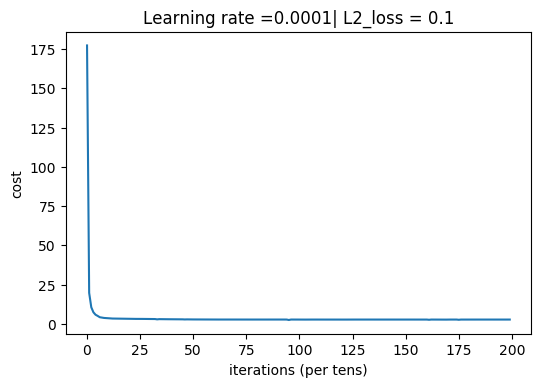

Parameters have been trained!
Testing... (Mean square loss Comparison)
('Testing cost=', 178.55664)
('Absolute mean square loss difference:', 175.86688152660022)


In [42]:
parameters = model(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, num_epochs=1000, 
                  l2_loss = 0.1, learning_rate = 0.0003, drop = 0.5, minibatch_size = 128)

# Búið

Núna ættum við að vera með fínt viðmið fyrir keyrslu á verkefninu. Getum analyzað meira til að sjá hvernig við bætum forspána mest. Ættum að greina hvort við séum að overfitta eða underfitta með því að keyra greininguna oft fyrir mismunandi úrtaksstærðir. 

## Hugmyndir að breytum:

Er stutt í hátíð? Kóða hátíðirnar inn í þetta. Spurning hvort það væri categorical eða numeric breyta.

Hreinsa olíuverðstöfluna og hafa olíuverðið með.